In [1]:
import sys
import os

# Add the parent directory to the system path to access 'utils'
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(parent_dir)
sys.path.append(parent_dir)

## Parmaters

In [2]:
model = "azure/gpt-4o-mini"
latex_ground_truth_file = "metric_data_examples/cut2.tex"
pdf_file_location = "metric_data_examples/cut2.pdf"

prompt = """
You are an expert system that converts PDF files to Latex

The following are prior information about the structure of the input documents. You should pay attention to them and use them to better convert the input file to the target formats:
- File pages are well organized, their structure should be preserved in the output format.
- Each page should return a single document section with all the page's content as subsections inside it.
- Use consistent section keys for all pages
- Pages can contain one or more titles with nested subtitles, their relationship should be well respected.
- Pages can contain single column or multicolumn text
- Pages can contain lists in a bullet point, numeric, or any format. Try to use a unified format for them. 
- Pages can contain one or more tables, with or without additional text that doesn’t belong to the table. 
- For each table, identify its content and caption. 
- If the page contains tables and paragraphs, return both. 

The following are common mistakes that you used to do. Avoid them as much as you can:
- You mistake tables for sections and subsections. Make sure to identify tables and sections separately.
- Some two-column texts have line-wide tables, and vice versa. Do not be confused by it. 
- Avoid removing an entire column and pretend that is doesnt exist


Return only the latex with no explanation text.
"""

## Pdf to latex

In [3]:
from pyzerox import zerox

result = await zerox(file_path=pdf_file_location, model=model, select_pages=None ,custom_system_prompt=prompt) ## select_pages=None is for all pages

concated_text = ""

for page in result.pages:
    concated_text += page.content + "\n"

predicted_latex = concated_text

with open(latex_ground_truth_file) as f:
    ground_truth_latex = f.read()    

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mohammad-dallash-vm1/code/Users/mohammad.dallash/zerox/py_zerox/pyzerox/models/modellitellm.py:52: UserWarning: 
    Custom system prompt was provided which overrides the default system prompt. We assume that you know what you are doing.  
    . Default prompt for zerox is:
 
    Convert the following PDF page to markdown.
    Return only the markdown with no explanation text.
    Do not exclude any content from the page.
    
  warnings.warn(f"{Messages.CUSTOM_SYSTEM_PROMPT_WARNING}. Default prompt for zerox is:\n {DEFAULT_SYSTEM_PROMPT}")


## Latex to Json

In [4]:
from utils.latex_to_json import tex_file_to_json
ground_truth_json = tex_file_to_json(tex_data= ground_truth_latex)
predicted_json = tex_file_to_json(tex_data= predicted_latex)

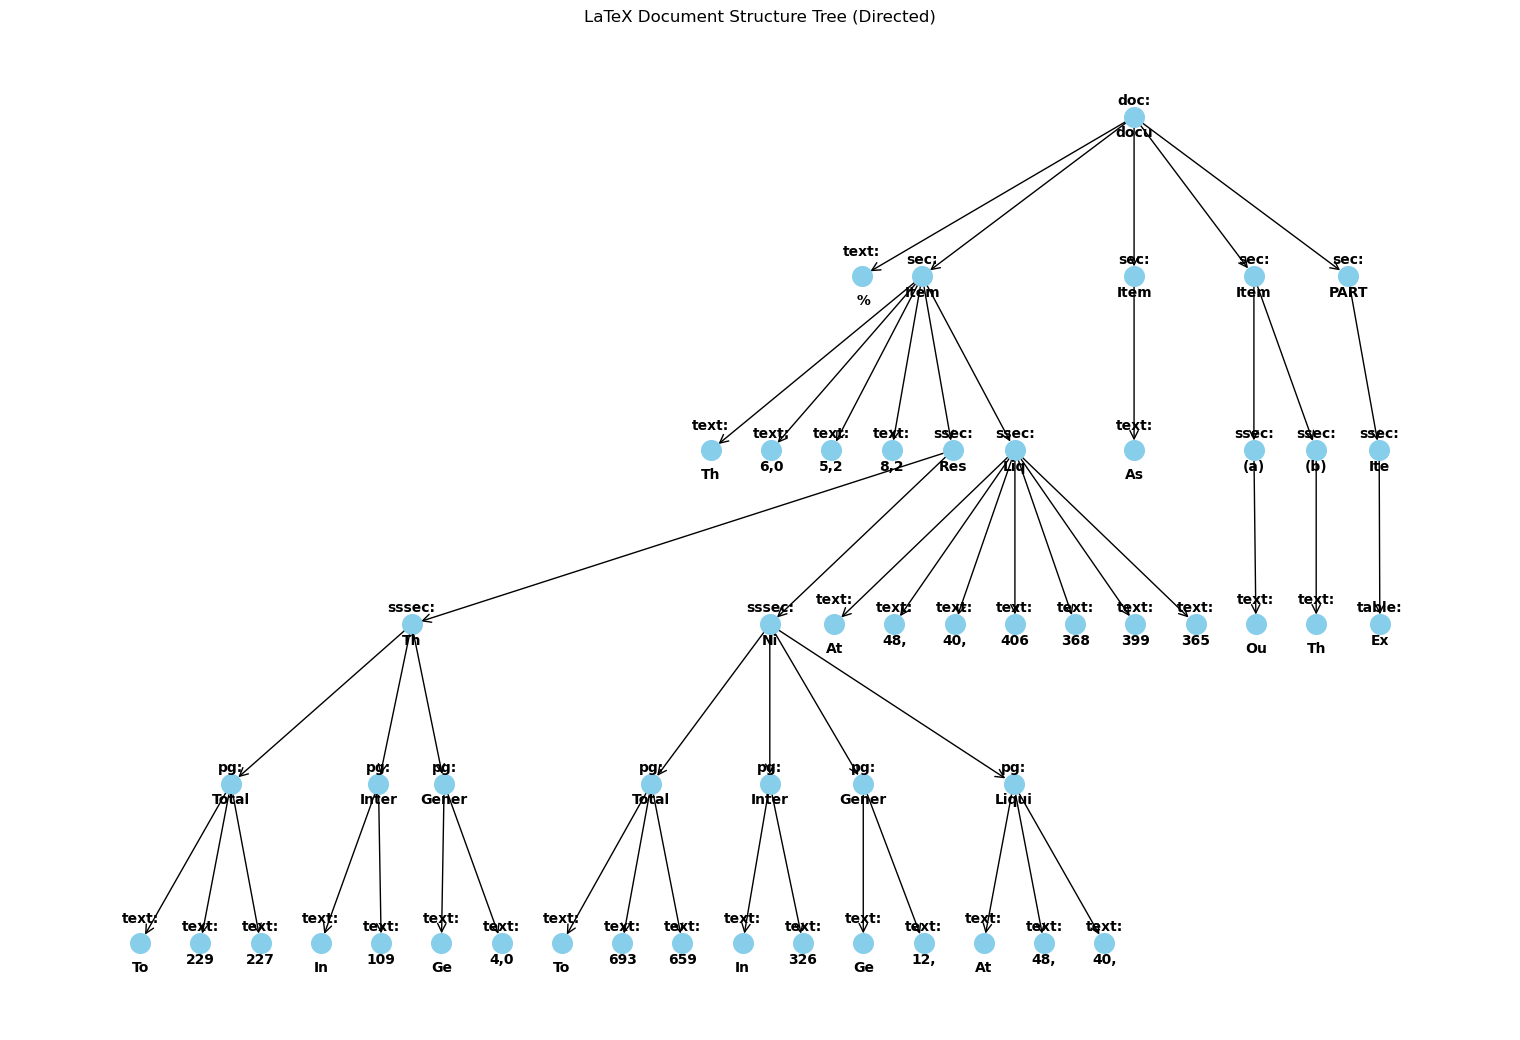

In [5]:
from utils.graph_plotter import draw_dict


draw_dict(ground_truth_json, 10) ##limit any text in the plot to 50 characters

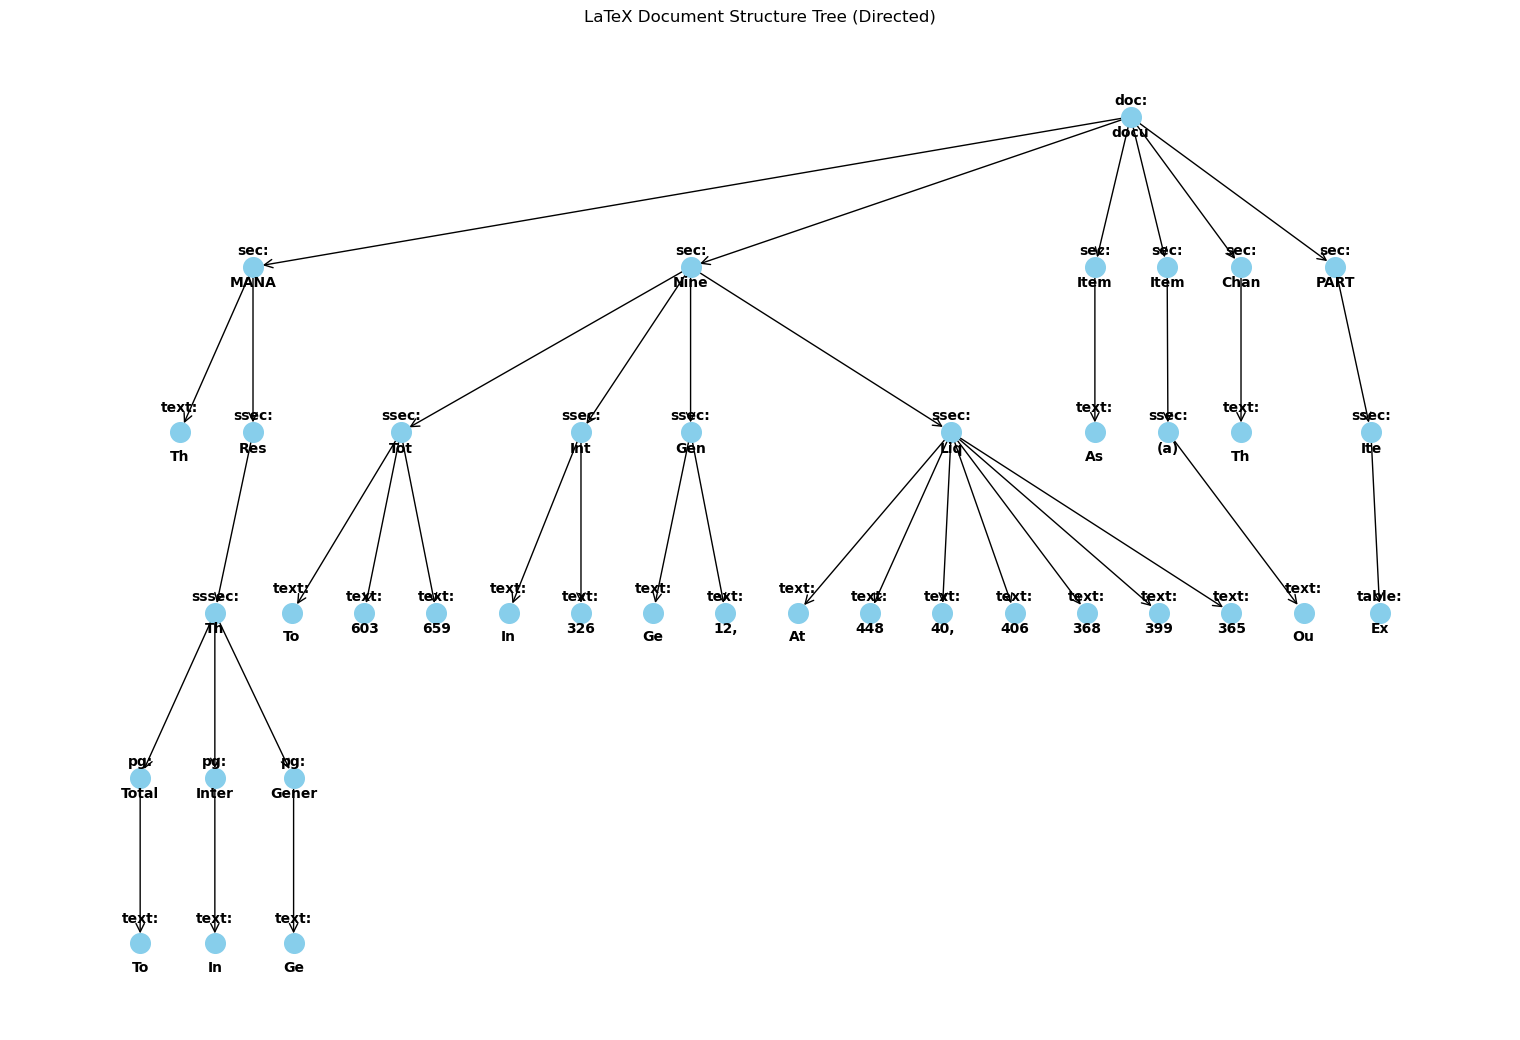

In [6]:
draw_dict(predicted_json, text_limit=10)

## Standardize headings

In [7]:
import json
from utils.heading_normalizer import  normalize_headings


# Assuming pred_json and gt_json are your input JSONs
updated_pred_json, changes = normalize_headings(ground_truth_json, predicted_json , "/home/azureuser/cloudfiles/code/Users/omar.bayoumi/zerox/py_zerox/metric_data_examples/logs.txt")


## Text Block Extractor

In [8]:
from utils.textblock_extractor import extract_text
# Get the list of dictionaries with headings and concatenated text
pred_dict = extract_text(updated_pred_json)
print(pred_dict)

{"MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS": '\nThe following discussion and analysis of our financial condition and results of operations should be read in conjunction with our unaudited financial statements and notes thereto included in this Quarterly Report on Form 10-Q. The discussion and analysis contains forward-looking statements based on current expectations that involve risks and uncertainties. Actual results and the timing of certain events may differ significantly from those projected in such forward-looking statements.\n\n\nWe are a wholly-owned subsidiary of Manhattan Bridge Capital, Inc.,, a New York corporation (“MBC”), and were formed in December 2015 specifically for the purpose of the initial public offering (“IPO”) of the Notes (described below). On April 25, 2016, we sold 6,000,000 aggregate principal amount of our 6% Senior Secured Notes, due April 22, 2026 (the “Notes”), in our IPO for net proceeds of 5,200,000, after d

In [9]:
GT_dict = extract_text(ground_truth_json)
print(GT_dict)

{"Item 2. MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS": '\nThe following discussion and analysis of our financial condition and results of operations should be read in conjunction with our unaudited financial statements and notes thereto included in this Quarterly Report on Form 10-Q. The discussion and analysis contains forward-looking statements based on current expectations that involve risks and uncertainties. Actual results and the timing of certain events may differ significantly from those projected in such forward-looking statements.\n\n\nWe are a wholly-owned subsidiary of Manhattan Bridge Capital, Inc.,, a New York corporation (“MBC”), and were formed in December 2015 specifically for the purpose of the initial public offering (“IPO”) of the Notes (described below). On April 25, 2016, we sold 6,000,000 aggregate principal amount of our 6% Senior Secured Notes, due April 22, 2026 (the “Notes”), in our IPO for net proceeds of 5,200,000,

In [10]:
from utils.textblock_extractor import find_and_matching_values

matching_values = find_and_matching_values(pred_dict, GT_dict)

print(matching_values)

[('\nOur management, including our chief executive officer and chief financial officer, evaluated the effectiveness of our disclosure controls and procedures (as defined in Rules 13a-15e and 15d-15e) under the Exchange Act as of September 30, 2024 (the “Evaluation Date”). Based upon that evaluation, the chief executive officer and the chief financial officer concluded that, as of the Evaluation Date, our disclosure controls and procedures are effective to ensure that information required to be disclosed by us in the reports that we file or submit under the Exchange Act are recorded, processed, summarized and reported, within the time periods specified in the SEC’s rules and forms and (ii) are accumulated and communicated to our management, including our chief executive officer and chief financial officer, as appropriate to allow timely decisions regarding required disclosure.\n\n', '\nOur management, including our chief executive officer and chief financial officer, evaluated the effec

In [11]:
from evaluation_metrics.text_similarity import calculate_rouge_metrics
rouge_values =calculate_rouge_metrics(matching_values)
print(rouge_values)

{'micro_scores_per_pair': [1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0], 'macro_rouge_l': 0.94, 'micro_average_rouge_l': np.float64(0.45)}


In [12]:
from evaluation_metrics.text_similarity import calculate_bleu_metrics
bleu_values =calculate_bleu_metrics(matching_values)
print(bleu_values)

{'bleu_scores_per_pair': [1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0], 'average_bleu': np.float64(0.4545)}


## DAR metric

In [13]:
from evaluation_metrics.DAR import evaluate_hierarchy
try:
    metrics = evaluate_hierarchy(ground_truth_json, updated_pred_json)
    print(metrics)
except Exception as e:
    print(f"Error during evaluation: {e}")

{'parent_child': {'precision': 0.7755102040816326, 'recall': 0.7755102040816326, 'f1': 0.7755102040816326, 'accuracy': 0.6333333333333333}, 'sibling': {'precision': 0.8787878787878788, 'recall': 0.8787878787878788, 'f1': 0.8787878787878788, 'accuracy': 0.7837837837837838}, 'combined': {'precision': 0.8347826086956521, 'recall': 0.8347826086956521, 'f1': 0.8347826086956521, 'accuracy': 0.7164179104477612}}
